In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
      self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
      return self

    def transform(self, X):
      rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
      rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
      population_per_household = X[:, population_ix] / X[:, households_ix]
      if self.add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

      else:
        return np.c_[X, rooms_per_household, population_per_household]

class RegressorPipeline:
  def __init__(self):
    self.model = None

  def load_data(self):
    os.chdir('/content/drive/MyDrive/handson-ml2')
    housing_path = os.path.join("datasets", "housing")
    csv_path = os.path.join(housing_path, "housing.csv")
    housing = pd.read_csv(csv_path)
    return housing

  def split_data(self, housing):
    # train, test 데이터 나누기
    train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

    # 계층적 샘플링
    housing["income_cat"] = pd.cut(housing["median_income"],
                                   bins=[0., 1.5, 3., 4.5, 6., np.inf],
                                   labels=[1, 2, 3, 4, 5])
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing, housing["income_cat"]):
      strat_train_set = housing.loc[train_index]
      strat_test_set = housing.loc[test_index]
    print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

    for set_ in (strat_train_set, strat_test_set):
      set_.drop("income_cat", axis=1, inplace=True)
    return train_set, test_set, strat_train_set, strat_test_set

  def data_visualizations(self, strat_train_set):
    # 지리적 시각화
    housing_dv = strat_train_set.copy()
    housing_dv.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
               s=housing_dv["population"]/100, label="population", figsize=(10,8),
               c=housing_dv["median_house_value"], cmap=plt.get_cmap("jet"), colorbar=True,
               sharex=False)
    plt.legend()

    # 상관관계
    corr_matrix = housing_dv.corr()
    print(corr_matrix["median_house_value"].sort_values(ascending=False))

    # 상관관계 시각화
    attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
    scatter_matrix(housing_dv[attributes], figsize=(12,8))
    housing_dv.plot(kind="scatter", x="median_income", y="median_house_value")

  def data_preprocessing(self, strat_train_set, CombinedAttributesAdder):
    # 데이터 셋팅
    housing_dp = strat_train_set.drop("median_house_value", axis=1)
    housing_dp_labels = strat_train_set[["median_house_value"]].copy()
    housing_num = housing_dp.drop("ocean_proximity", axis=1)

    attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
    housing_extra_attribs = attr_adder.transform(housing_dp.values)

    # 수치형 파이프라인 생성
    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])
    housing_num_tr = num_pipeline.fit_transform(housing_num)

    # 범주형 파이프라인 생성
    num_attribs = list(housing_num)
    cat_attribs = ["ocean_proximity"]

    full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])
    housing_prepared = full_pipeline.fit_transform(housing_dp)
    return housing_dp, housing_dp_labels, housing_num, housing_num_tr, housing_prepared, num_pipeline, full_pipeline, num_attribs, cat_attribs

  def model_select(self, housing_prepared, housing_dp_labels):
    # 교차 검증 출력
    def display_scores(scores):
      print("점수:", scores)
      print("평균:", scores.mean())
      print("표준편차:", scores.std())

    # LinearRegression
    lin_reg = LinearRegression()
    lin_reg.fit(housing_prepared, housing_dp_labels)
    housing_lin_predictions = lin_reg.predict(housing_prepared)
    lin_reg_mse = mean_squared_error(housing_dp_labels, housing_lin_predictions)
    lin_reg_rmse = np.sqrt(lin_reg_mse)

    lin_reg_score = cross_val_score(lin_reg, housing_prepared, housing_dp_labels,
                                     scoring="neg_mean_squared_error", cv=10)
    lin_reg_scores = np.sqrt(-lin_reg_score)
    display_scores(lin_reg_scores)

    # DecisionTreeRegressor
    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(housing_prepared, housing_dp_labels)
    housing_tree_predictions = tree_reg.predict(housing_prepared)
    tree_reg_mse = mean_squared_error(housing_dp_labels, housing_tree_predictions)
    tree_reg_rmse = np.sqrt(tree_reg_mse)

    tree_reg_score = cross_val_score(tree_reg, housing_prepared, housing_dp_labels,
                                     scoring="neg_mean_squared_error", cv=10)
    tree_reg_scores = np.sqrt(-tree_reg_score)
    display_scores(tree_reg_scores)

    # RandomForestRegressor
    forest_reg = RandomForestRegressor()
    forest_reg.fit(housing_prepared, housing_dp_labels)
    housing_forest_predictions = forest_reg.predict(housing_prepared)
    forest_reg_mse = mean_squared_error(housing_dp_labels, housing_forest_predictions)
    forest_reg_rmse = np.sqrt(forest_reg_mse)

    forest_reg_score = cross_val_score(forest_reg, housing_prepared, housing_dp_labels,
                                     scoring="neg_mean_squared_error", cv=10)
    forest_reg_scores = np.sqrt(-forest_reg_score)
    display_scores(forest_reg_scores)

    # 모델 비교
    if (lin_reg_scores.mean() > tree_reg_scores.mean()):
      if (tree_reg_scores.mean() > forest_reg_scores.mean()):
        model = RandomForestRegressor()
      else:
        model = DecisionTreeRegressor()
    else:
      if (lin_reg_scores.mean() > forest_reg_scores.mean()):
        model = RandomForestRegressor()
      else:
        model = LinearRegression()
    print(model)

    return model

  def hyperparameter_searching(self, model, housing_prepared, housing_dp_labels, num_attribs, full_pipeline):
    # 하이퍼파라미터 설정
    param_grid = [
        {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]},
    ]

    # 최적의 하이퍼파리미터 찾기
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
    grid_search.fit(housing_prepared, housing_dp_labels)
    print(grid_search.best_estimator_)

    # 최상의 모델 확인
    feature_importances = grid_search.best_estimator_.feature_importances_

    extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
    cat_encoder = full_pipeline.named_transformers_["cat"]
    cat_one_hot_attribs = list(cat_encoder.categories_[0])
    attributes = num_attribs + extra_attribs + cat_one_hot_attribs
    print(sorted(zip(feature_importances, attributes), reverse=True))

    return grid_search

  def test_evaluation(self, grid_search, full_pipeline):
    # 테스트 세트 평가
    final_model = grid_search.best_estimator_

    x_test = strat_test_set.drop("median_house_value", axis=1)
    y_test = strat_test_set["median_house_value"].copy()

    x_test_prepared = full_pipeline.transform(x_test)

    final_predictions = final_model.predict(x_test_prepared)

    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)
    print(final_rmse)

    return x_test, y_test, final_predictions

  def confidence_evaluation(self, final_predictions, y_test):
    confidence = 0.95
    squared_errors = (final_predictions - y_test) ** 2
    np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                              loc=squared_errors.mean(),
                              scale=stats.sem(squared_errors)))


3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


<ipython-input-38-0617ca0530da>:81: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_dv.corr()


점수: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균: 69104.07998247063
표준편차: 2880.3282098180634
점수: [71987.43573147 70835.88413478 68745.47396796 72108.49144857
 68692.04005884 78758.62547395 70126.84512156 72813.71339707
 69068.84800624 70678.26365408]
평균: 71381.56209945257
표준편차: 2815.412478965102


<ipython-input-38-0617ca0530da>:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(housing_prepared, housing_dp_labels)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

점수: [52022.31432011 48903.00244177 46912.57656265 52014.41896549
 47167.21193728 51569.63270893 52086.65440637 49612.51114795
 48605.49541795 53514.81896539]
평균: 50240.86368738733
표준편차: 2181.6135680555276
RandomForestRegressor()


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

RandomForestRegressor(max_features=8, n_estimators=30)
[(0.3799071271323907, 'median_income'), (0.15076025280640268, 'INLAND'), (0.11447688594372016, 'pop_per_hhold'), (0.0674925734811913, 'longitude'), (0.06341927303193798, 'latitude'), (0.059304212646568016, 'bedrooms_per_room'), (0.052396390521552205, 'rooms_per_hhold'), (0.043648122233086804, 'housing_median_age'), (0.015200268084205657, 'total_rooms'), (0.015033695166367194, 'population'), (0.014525930955422024, 'households'), (0.014474761484889373, 'total_bedrooms'), (0.0045562590024791905, '<1H OCEAN'), (0.0028149667926812127, 'NEAR OCEAN'), (0.001893326467386195, 'NEAR BAY'), (9.595424971922687e-05, 'ISLAND')]
47780.19212304527


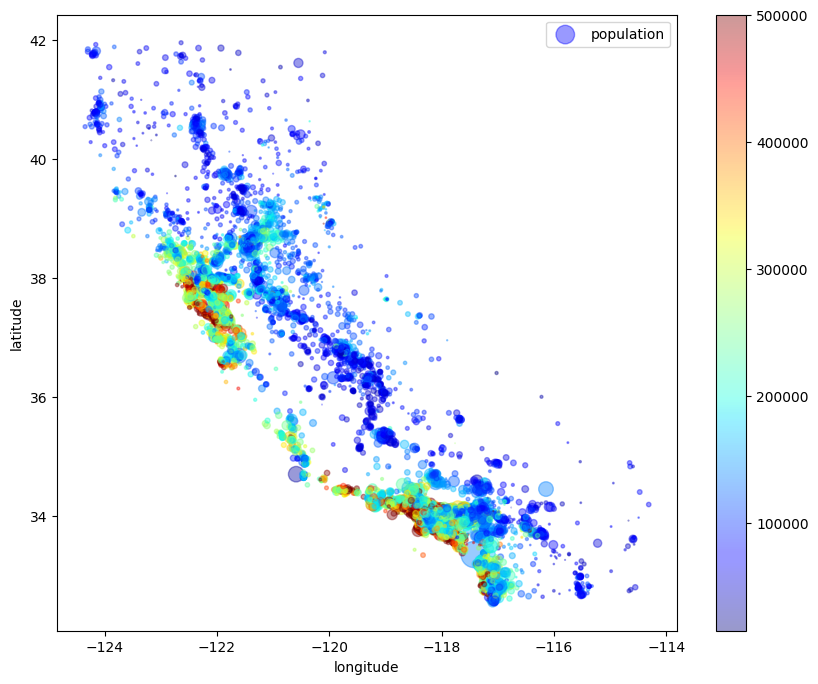

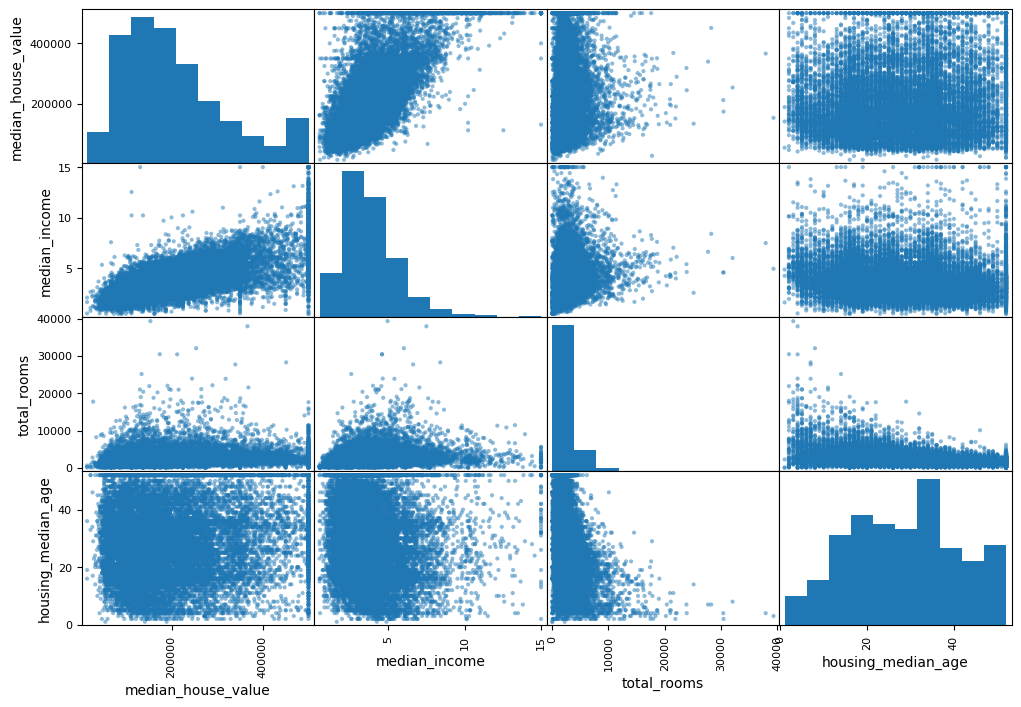

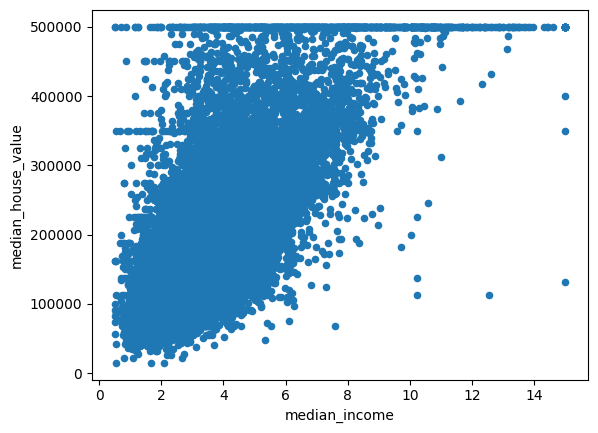

In [ ]:
pipeline = RegressorPipeline()
housing = pipeline.load_data()
train_set, test_set, strat_train_set, strat_test_set = pipeline.split_data(housing)
pipeline.data_visualizations(strat_train_set)
housing_dp, housing_dp_labels, housing_num, housing_num_tr, housing_prepared, num_pipeline, full_pipeline, num_attribs, cat_attribs = pipeline.data_preprocessing(strat_train_set, CombinedAttributesAdder)
model = pipeline.model_select(housing_prepared, housing_dp_labels)
grid_search = pipeline.hyperparameter_searching(model, housing_prepared, housing_dp_labels, num_attribs, full_pipeline)
x_test, y_test, final_predictions = pipeline.test_evaluation(grid_search, full_pipeline)
pipeline.confidence_evaluation(final_predictions, y_test)